<a href="https://colab.research.google.com/github/RonanD10/Tennis-Match-Prediction/blob/main/4_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F

from google.colab import drive, files
drive.mount('/content/drive')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

Mounted at /content/drive


In [ ]:
features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Tennis Project/features_processed_random.csv')

In [ ]:
features

,A_rank,B_rank,A_elo_surface,B_elo_surface,A_elo,B_elo,A_avged_elo,B_avged_elo,A_wins,B_wins,A_wins_surface,B_wins_surface,A_12month_form,B_12month_form,A_12month_form_surface,B_12month_form_surface,slam_round,A_won,elo_difference,surface_carpet,surface_clay,surface_grass,surface_hard
0,3.0,23.0,1988.523,1644.770,2151.654,1772.521,2070.0885,1708.6455,0,0,0,0,0.833333,0.000000,0.833333,0.000000,1,1,379.133,False,False,True,False
1,22.0,30.0,1584.360,1501.014,1859.956,1714.681,1722.1580,1607.8475,0,0,0,0,0.666667,0.000000,0.666667,0.000000,1,1,145.275,False,False,True,False
2,55.0,58.0,1554.535,1792.652,1712.486,1821.925,1633.5105,1807.2885,0,0,0,0,0.500000,0.000000,0.500000,0.000000,1,1,109.439,False,False,True,False
3,39.0,15.0,1542.475,1740.677,1794.640,1885.650,1668.5575,1813.1635,0,0,0,0,0.000000,0.750000,0.000000,0.750000,1,0,91.010,False,False,True,False
4,97.0,18.0,1503.159,1766.935,1607.397,1922.537,1555.2780,1844.7360,0,0,0,0,0.000000,0.666667,0.000000,0.666667,1,0,315.140,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144634,7.0,56.0,1901.149,1590.551,1926.081,1684.596,1913.6150,1637.5735,0,0,0,0,0.717949,0.515152,0.783784,0.533333,0,1,241.485,False,True,False,False
144635,29.0,47.0,1694.263,1672.773,1724.848,1698.955,1709.5555,1685.8640,0,0,0,0,0.525424,0.680000,0.617647,0.708333,0,1,25.893,False,True,False,False
144636,19.0,117.0,1554.270,1542.649,1797.649,1567.658,1675.9595,1555.1535,1,0,0,0,0.603448,0.700000,0.500000,0.833333,0,0,229.991,False,True,False,False
144637,7.0,44.0,1905.735,1605.691,1932.462,1796.400,1919.0985,1701.0455,1,0,0,0,0.717949,0.636364,0.783784,0.666667,0,1,136.062,False,True,False,False


In [ ]:
# Overall data
X = features.drop(['A_won', 'slam_round'], axis=1)
y = features['A_won']
X_train = X[:int(0.8 * len(X))]
y_train = y[:int(0.8 * len(y))]
X_test = X[int(0.8 * len(y)):]
y_test = y[int(0.8 * len(y)):]

# Slam data
slam_features = features[features['slam_round'] > 0]
slam_features.reset_index(inplace=True, drop=True)
X_train_slam = slam_features[:int(0.8 * len(slam_features))]
y_train_slam = X_train_slam['A_won']
X_train_slam = X_train_slam.drop(['A_won', 'slam_round'], axis=1)
X_test_slam = slam_features[int(0.8 * len(slam_features)):]
X_test_slam = X_test_slam[X_test_slam['slam_round'] > 0]
y_test_slam = X_test_slam['A_won']
X_test_slam = X_test_slam.drop(['A_won', 'slam_round'], axis=1)

# Top-100-ranking data
rank_features = features[(features['A_rank'] <= 100) & (features['B_rank'] <= 100)]
rank_features.reset_index(inplace=True, drop=True)
X_train_rank = rank_features[:int(0.8 * len(rank_features))]
y_train_rank = X_train_rank['A_won']
X_train_rank = X_train_rank.drop(['A_won', 'slam_round'], axis=1)
X_test_rank = rank_features[int(0.8 * len(rank_features)):]
X_test_rank = X_test_rank[X_test_rank['slam_round'] > 0]
y_test_rank = X_test_rank['A_won']
X_test_rank = X_test_rank.drop(['A_won', 'slam_round'], axis=1)

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_slam = scaler.fit_transform(X_train_slam)
X_test_slam = scaler.transform(X_test_slam)
X_train_rank = scaler.fit_transform(X_train_rank)
X_test_rank = scaler.transform(X_test_rank)

In [ ]:
# Comparing models

models = [LogisticRegression(), RandomForestClassifier()]

# Overall predictions
print('(Overall predictions)')
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model.__class__.__name__} accuracy: {accuracy}')

# Slam predictions only
print('\n(Slam predictions)')
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_slam)
    accuracy = accuracy_score(y_test_slam, y_pred)
    print(f'{model.__class__.__name__} accuracy: {accuracy}')

# Slam predictions, trained only on slam data
print('\n(Slam predictions from slam data)')
for model in models:
    model.fit(X_train_slam, y_train_slam)
    y_pred = model.predict(X_test_slam)
    accuracy = accuracy_score(y_test_slam, y_pred)
    print(f'{model.__class__.__name__} accuracy: {accuracy}')

# Predictions of top-100-ranked matches
print('\n(Top-100-ranked matches)')
for model in models:
    model.fit(X_train_rank, y_train_rank)
    y_pred = model.predict(X_test_rank)
    accuracy = accuracy_score(y_test_rank, y_pred)
    print(f'{model.__class__.__name__} accuracy: {accuracy}')

(Overall predictions)
LogisticRegression accuracy: 0.7655904314159292
RandomForestClassifier accuracy: 0.7724004424778761

(Slam predictions)
LogisticRegression accuracy: 0.8018058690744921
RandomForestClassifier accuracy: 0.808803611738149

(Slam predictions from slam data)
LogisticRegression accuracy: 0.8047404063205418
RandomForestClassifier accuracy: 0.8081264108352144

(Top-100-ranked matches)
LogisticRegression accuracy: 0.7812101910828025
RandomForestClassifier accuracy: 0.7840764331210192


In [ ]:
# Benchmarking baseline models

# Predicting outcome based only on ranking
correct = 0
for i in range(len(features)):
    if features.loc[i, 'A_rank'] < features.loc[i, 'B_rank'] and features.loc[i, 'A_won'] == 1:
        correct += 1
    elif features.loc[i, 'A_rank'] > features.loc[i, 'B_rank'] and features.loc[i, 'A_won'] == 0:
        correct += 1
    else:
        pass

print('Rank accuracy: ', correct/len(features))

# Predicting outcome based only on Elo
correct = 0
for i in range(len(features)):
    if features.loc[i, 'A_elo'] > features.loc[i, 'B_elo'] and features.loc[i, 'A_won'] == 1:
        correct += 1
    elif features.loc[i, 'A_elo'] < features.loc[i, 'B_elo'] and features.loc[i, 'A_won'] == 0:
        correct += 1
    else:
        pass

print('Elo accuracy: ', correct/len(features))

# Predicting outcome based only on 12 month form
correct = 0
for i in range(len(features)):
    if features.loc[i, 'A_12month_form'] > features.loc[i, 'B_12month_form'] and features.loc[i, 'A_won'] == 1:
        correct += 1
    elif features.loc[i, 'A_12month_form'] < features.loc[i, 'B_12month_form'] and features.loc[i, 'A_won'] == 0:
        correct += 1
    else:
        pass

print('12-month form accuracy: ', correct/len(features))

Rank accuracy:  0.6595385753496636
Elo accuracy:  0.6650834145700676
12-month form accuracy:  0.718582125152967


In [ ]:
# Accuracy per slam round

model = RandomForestClassifier()
for i in range(1, 8):
    X_test_sround = slam_features[:int(0.8 * len(slam_features))]
    X_test_sround = X_test_sround[X_test_sround['slam_round'] == i]
    y_test_sround = X_test_sround['A_won']
    X_test_sround = X_test_sround.drop(['A_won', 'slam_round'], axis=1)
    X_test_sround = scaler.fit_transform(X_test_sround)

    model.fit(X_train_slam, y_train_slam)
    y_pred = model.predict(X_test_sround)
    accuracy = accuracy_score(y_test_sround, y_pred)
    print(f'Accuracy for slam round {i}: {accuracy}')

Accuracy for slam round 1: 0.8328431949182449
Accuracy for slam round 2: 0.8552166224580018
Accuracy for slam round 3: 0.7796178343949045
Accuracy for slam round 4: 0.7761557177615572
Accuracy for slam round 5: 0.7567567567567568
Accuracy for slam round 6: 0.75
Accuracy for slam round 7: 0.7625


In [ ]:
# Accuracy at predicting ranking upsets

model = RandomForestClassifier()
y_pred = model.fit(X_train_slam, y_train_slam)

y_pred = list(model.predict(X_test_slam))
y_test_slam_list = list(y_test_slam)

correct_upsets = 0
incorrect_upsets = 0
for i in range(len(X_test_slam)):
    j = len(X_train_slam) + i
    if (slam_features.loc[j, 'A_rank'] > slam_features.loc[j, 'B_rank']) and (y_pred[i] == 1 and y_test_slam_list[i] == 1):
        correct_upsets += 1
    if (slam_features.loc[j, 'A_rank'] < slam_features.loc[j, 'B_rank']) and (y_pred[i] == 0 and y_test_slam_list[i] == 0):
        correct_upsets += 1
    if (slam_features.loc[j, 'A_rank'] > slam_features.loc[j, 'B_rank']) and (y_pred[i] == 1 and y_test_slam_list[i] == 0):
        incorrect_upsets += 1
    if (slam_features.loc[j, 'A_rank'] < slam_features.loc[j, 'B_rank']) and (y_pred[i] == 0 and y_test_slam_list[i] == 1):
        incorrect_upsets += 1
    j += 1

print(f'Upset accuracy: {correct_upsets / (correct_upsets + incorrect_upsets)}')

Upset accuracy: 0.7125628140703517


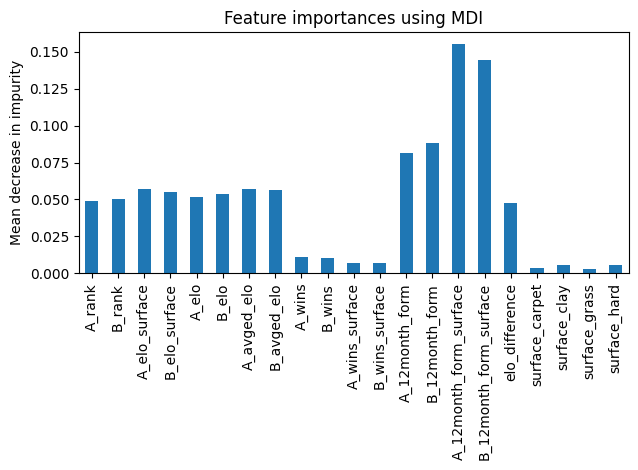

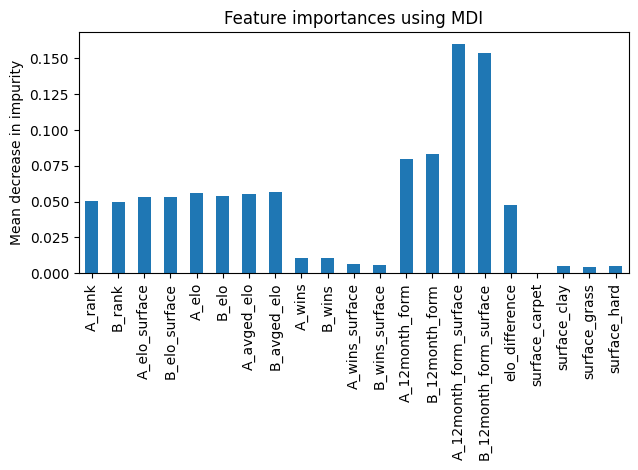

In [ ]:
# Feature importances

# Overall dataset
rfr = RandomForestClassifier()
rfr.fit(X_train, y_train)

importances = rfr.feature_importances_
imporances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
imporances.plot.bar()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

# Slam data
rfr.fit(X_train_slam, y_train_slam)
importances = rfr.feature_importances_
imporances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
imporances.plot.bar()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

In [ ]:
# Logistic regression feature importances
model = LogisticRegression()
model.fit(X_train, y_train)
model.coef_

<Axes: xlabel='A_wins'>

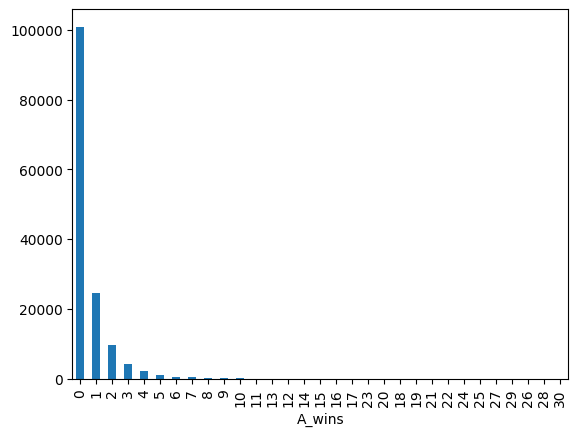

In [ ]:
features['A_wins'].value_counts().plot(kind='bar')

In [ ]:
# Dropping surface features and h2h
features_new = features.drop(['surface_carpet', 'surface_clay', 'surface_grass', 'surface_hard', 'A_wins', 'B_wins', 'A_wins_surface', 'B_wins_surface'], axis=1)

# Check updated accuracy
X_train_new = features_new[:int(0.8 * len(features_new))]
y_train_new = X_train_new['A_won']
X_train_new = X_train_new.drop(['A_won', 'slam_round'], axis=1)
X_test_new = features_new[int(0.8 * len(features_new)):]
y_test_new = X_test_new['A_won']
X_test_new = X_test_new.drop(['A_won', 'slam_round'], axis=1)

X_train_new = scaler.fit_transform(X_train_new)
X_test_new = scaler.transform(X_test_new)

model = RandomForestClassifier()
model.fit(X_train_new, y_train_new)
y_pred = model.predict(X_test_new)
accuracy = accuracy_score(y_test_new, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7711905420353983


In [ ]:
# LATER:

    # Add previous (e.g. 2, 5) match stats -- serve%, pressure point%
    # Add week-before tournament stats -- fatigue factor (deep in tournament?), time spent on court
    # Add stats on historic performance at tournament

# Import features with added 6-month, 3-month, 1-month form + surface form to emphasise form imporance


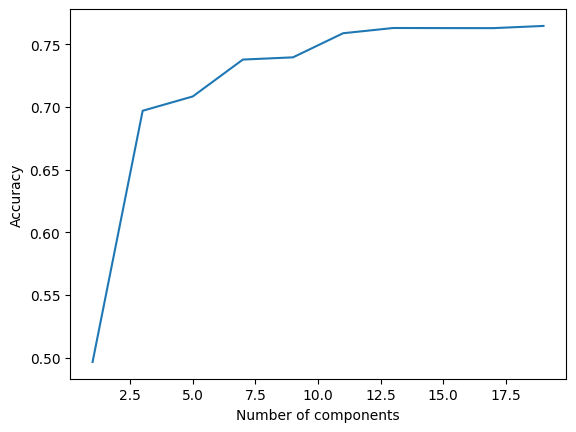

In [ ]:
# Principal component analysis

# Principal component number vs model accuracy
accuracies_cn = []
for i in range(1, 21, 2):
    pca = PCA(n_components=i)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    model = RandomForestClassifier()
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)

    accuracies_cn.append(accuracy)

plt.plot(range(1, 21, 2), accuracies_cn)
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Variance vs model accuracy
accuracies_var = []
for i in np.arange(0.8, 1, 0.02):
    pca = PCA(i)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    model = RandomForestClassifier()
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies_var.append(accuracy)

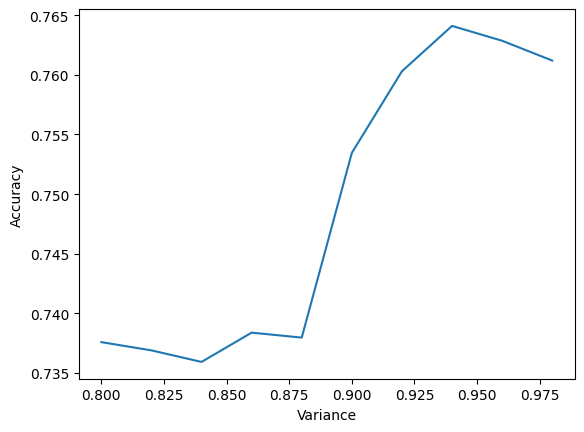

In [ ]:
plt.plot(np.arange(0.8, 1, 0.02), accuracies_var)
plt.xlabel('Variance')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
pca_components = pd.DataFrame({'Number of components': range(1, 21, 2), 'Accuracy': accuracies_cn})
pca_variance = pd.DataFrame({'Variance': np.arange(0.8, 1, 0.02), 'Accuracy': accuracies_var})
pca_components

,Number of components,Accuracy
0,1,0.496647
1,3,0.696937
2,5,0.708345
3,7,0.737763
4,9,0.739526
5,11,0.758746
6,13,0.762929
7,15,0.762860
8,17,0.762825
9,19,0.764588


In [ ]:
pca_variance

,Variance,Accuracy
0,0.80,0.737590
1,0.82,0.736899
2,0.84,0.735931
3,0.86,0.738385
4,0.88,0.737970
5,0.90,0.753457
6,0.92,0.760301
7,0.94,0.764104
8,0.96,0.762860
9,0.98,0.761200


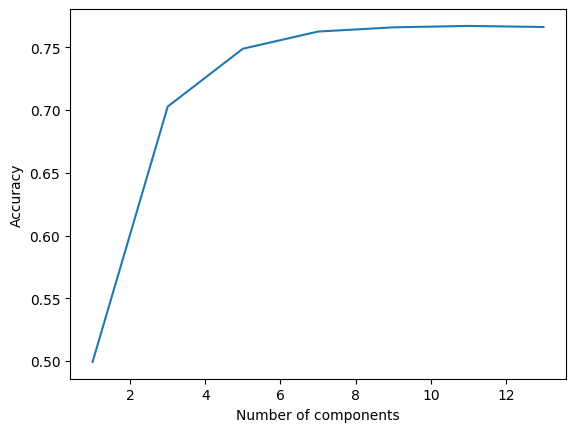

In [ ]:
# PCA on reduced feature set

accuracies_cn = []
for i in range(1, 15, 2):
    pca = PCA(n_components=i)
    X_train_pca = pca.fit_transform(X_train_new)
    X_test_pca = pca.transform(X_test_new)

    model = RandomForestClassifier()
    model.fit(X_train_pca, y_train_new)
    y_pred = model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)

    accuracies_cn.append(accuracy)

plt.plot(range(1, 15, 2), accuracies_cn)
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Deep learning NN model

class Model(nn.Module):
  def __init__(self, in_features=21, h1=24, h2=24, out_features=2):
    super().__init__()
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.out = nn.Linear(h2, out_features)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)

    return x

model = Model()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# NN accuracy

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(list(y_test))

epochs = 500
losses = []
for i in range(epochs):
  y_pred = model.forward(X_train)
  loss = criterion(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

# Overall accuracy
with torch.no_grad():
    y_eval = model.forward(X_test)
    loss = criterion(y_eval, y_test)
    print(f'Loss: {loss}')
    print(f'Accuracy: {accuracy_score(y_test, torch.argmax(y_eval, dim=1))}')

# Slam accuracy
X_test_slam = torch.FloatTensor(X_test_slam)
y_test_slam = torch.LongTensor(list(y_test_slam))
with torch.no_grad():
    y_eval = model.forward(X_test_slam)
    loss = criterion(y_eval, y_test_slam)
    print(f'Loss: {loss}')
    print(f'Slam accuracy: {accuracy_score(y_test_slam, torch.argmax(y_eval, dim=1))}')

Loss: 0.4548076391220093
Accuracy: 0.7722967367256637
Loss: 0.4118892550468445
Slam accuracy: 0.8063205417607223


In [ ]:
# Accuracy on reduced feature set

X_train = torch.FloatTensor(X_train_new)
X_test = torch.FloatTensor(X_test_new)

y_train = torch.LongTensor(y_train_new)
y_test = torch.LongTensor(list(y_test_new))

class Model(nn.Module):
  def __init__(self, in_features=13, h1=24, h2=24, out_features=2):
    super().__init__()
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.out = nn.Linear(h2, out_features)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)

    return x

model = Model()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 1000
losses = []
for i in range(epochs):
  y_pred = model.forward(X_train)
  loss = criterion(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

with torch.no_grad():
    y_eval = model.forward(X_test)
    loss = criterion(y_eval, y_test)
    print(f'Loss: {loss}')
    print(f'Accuracy: {accuracy_score(y_test, torch.argmax(y_eval, dim=1))}')

Loss: 0.4520585834980011
Accuracy: 0.7750967920353983
